<a href="https://colab.research.google.com/github/Colsai/scott_data606/blob/main/topic_modeling/Topic_Modeling_Initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HHS OIG Workplan Topic Modeling
## Initial Test of LDA Modeling
*A look through the current OIG work projects and group them using LDA.*

## Specific Questions on Work Plan Projects
1) What does OIG cite as major focus areas (as topics)?  
- How can we group OIG's work projects and products by topic?  

2) Do those topics line up with major focus areas that OIG specifices on their website? 

## Models:
1) **LDA Model**  
2) **BerTopic Model**


In [72]:
from IPython.display import clear_output

In [73]:
#Pip Install Missing Packages
!pip install pyLDAvis
!pip install bertopic
!pip install bertopic[visualization]
!python -m spacy download en_core_web_md -qq
clear_output()

In [74]:
###########################
# Packages                #
###########################
import pandas as pd
import sklearn
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models
import en_core_web_md
import gensim
import random
import pyLDAvis
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.test.utils import datapath
import warnings

warnings.filterwarnings('ignore')

# Set options for specific packages
nltk.download(['punkt', 
               'stopwords',
               'wordnet',
               'omw-1.4'])

# Visualise inside a notebook
pyLDAvis.enable_notebook()

sns.set()

clear_output()

In [75]:
###########################
# Load CSVs (Github)      #
###########################
workplan_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_workplan_summaries.csv?raw=true")

#Drop typo column
workplan_df.drop(columns = 'Office of Evaluation and Inspections', 
                 inplace = True)

reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

In [76]:
'''
# Save model to disk.
def save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', 
               model = Lda_model):
    temp_file = datapath([path])
    model.save(temp_file)

# Load a potentially pretrained model from disk.
def load_model(path = ''):
    saved_model = LdaModel.load(path)
    return saved_model
'''

"\n# Save model to disk.\ndef save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', \n               model = Lda_model):\n    temp_file = datapath([path])\n    model.save(temp_file)\n\n# Load a potentially pretrained model from disk.\ndef load_model(path = ''):\n    saved_model = LdaModel.load(path)\n    return saved_model\n"

## Latent Dirichlet Allocation (LDA) Model
Topic model by cleaning text and running it through an LDA model

In [77]:
workplan_df.head()

,Announced or Revised,Agency,Title,Component,Report Number(s),Expected Issue Date (FY),Website_Link,Summary
0,Completed,Administration for Children and Families,States' Accuracy of Reporting TANF Spending In...,Office of Audit Services,A-02-17-02005; W-00-17-25100,2021,https://oig.hhs.gov/reports-and-publications/w...,The Temporary Assistance for Needy Families (T...
1,Completed,Administration for Children and Families,Head Start: Review of Single Audit Findings an...,Office of Audit Services,"A-02-16-02009, A-09-16-01004, A-06-17-07003;...",2018,https://oig.hhs.gov/reports-and-publications/w...,Effective for awards made on or after December...
2,Completed,Administration for Children and Families,Unaccompanied Children Program Grantee Reviews,Office of Audit Services,A-02-16-02013; A-04-16-03566; A-02-16-02007;...,2020,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
3,Nov-16,Administration for Children and Families,Recommendation Follow-Up: Office of Refugee Re...,Office of Evaluation and Inspections,OEI-09-16-00260,2017,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
4,October 2020,Administration for Children and Families,ACF Oversight of Guardian Ad Litem Requirement...,Office of Evaluation and Inspections,OEI-12-16-00120,2022,https://oig.hhs.gov/reports-and-publications/w...,As a condition of receiving Child Abuse Preven...


In [78]:
###########################
# Data Cleaning           #
###########################
from nltk.stem import RegexpStemmer

stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (asp and amp were relics of links within the page)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',])

#Extend for more subject-based words
stopwords.extend([
                  'oig',
                  'hhs',
                  'amp',
                  'asp'])

###########################
# Tokenize                #
###########################
#Set tokenizer as regex tokenizer to remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in workplan_df["Summary"]]

tokenized_sums = [[i for i in tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
workplan_df["summary_tokenized"] = tokenized_stemmed_sums

workplan_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

In [79]:
#Sample Summaries
sample_item = workplan_df.sample(1)
line_limit = 20
print(sample_item["Summary"].iloc[0])
print(sample_item["summary_tokenized"].iloc[0])

Medicare makes the full Medicare Severity Diagnosis-Related Group (MS-DRG) payment to a hospital that discharges an inpatient beneficiary "to home."  However, for certain qualifying MS-DRGs under the post-acute-care transfer policy, Medicare pays hospitals a per diem rate when an inpatient beneficiary is transferred to post-acute care.  The per diem payment cannot exceed the full payment that would have been made if the beneficiary had been discharged to home.  A prior OIG review identified Medicare overpayments to hospitals that did not comply with the post-acute-care transfer policy (42 CFR § 412.4(c)).  OIG's review found that the CMS Common Working File (CWF) edits that detected inpatient claims under the post-acute care transfer policy were working appropriately.  However, some Medicare contractors did not receive automatic notifications of improperly billed claims or did not act to adjust those claims.  As a result, OIG recommended that CMS recover the identified overpayments in 

In [80]:
sample_item["Summary"].iloc[0]

'Medicare makes the full Medicare Severity Diagnosis-Related Group (MS-DRG) payment to a hospital that discharges an inpatient beneficiary "to home."  However, for certain qualifying MS-DRGs under the post-acute-care transfer policy, Medicare pays hospitals a per diem rate when an inpatient beneficiary is transferred to post-acute care.  The per diem payment cannot exceed the full payment that would have been made if the beneficiary had been discharged to home.  A prior OIG review identified Medicare overpayments to hospitals that did not comply with the post-acute-care transfer policy (42 CFR § 412.4(c)).  OIG\'s review found that the CMS Common Working File (CWF) edits that detected inpatient claims under the post-acute care transfer policy were working appropriately.  However, some Medicare contractors did not receive automatic notifications of improperly billed claims or did not act to adjust those claims.  As a result, OIG recommended that CMS recover the identified overpayments i

### Run LDA

In [81]:
###############################
# LDA Data: Normal LDA        #
###############################

dictionary = Dictionary(workplan_df["summary_tokenized"])

#Filter extreme token values (no tokens below 5, no tokens in over 60% of documents)
dictionary.filter_extremes(no_below=5, 
                           no_above=0.5, 
                           keep_n=1000)

corpus = [dictionary.doc2bow(doc) for doc in workplan_df["summary_tokenized"]]

#lda model parameters
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=200, 
                         num_topics=14,
                         workers = 8, 
                         passes=20)

### What is 'part' and 'b'?
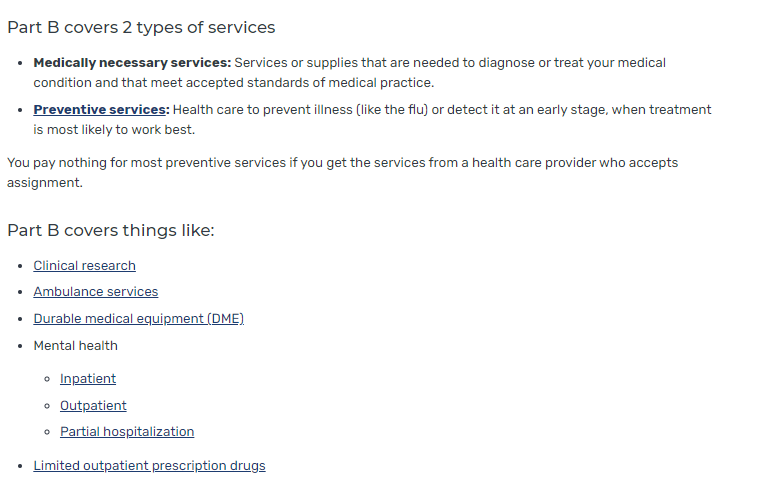

- https://www.medicare.gov/what-medicare-covers/what-part-b-covers

### Visualize and View Topics

In [82]:
#Visualize the model with pyLDAvis
lda_model_visualize = pyLDAvis.gensim_models.prepare(lda_model,
                                                     corpus = corpus, 
                                                     dictionary = dictionary)
lda_model_visualize

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.108841  0.034773       1        1  18.556695
10     0.098312 -0.062495       2        1  17.784295
4      0.150764  0.045658       3        1   9.524732
13     0.049541 -0.002508       4        1   8.248155
6      0.129697 -0.068207       5        1   6.388930
5      0.083368 -0.044634       6        1   5.649638
3     -0.187670 -0.044216       7        1   5.622035
11     0.080405 -0.061044       8        1   5.171328
0     -0.121016  0.054485       9        1   4.842257
2     -0.117456  0.267648      10        1   4.071680
12    -0.083737 -0.045590      11        1   4.066364
7      0.084805  0.105970      12        1   3.657938
9     -0.227034 -0.171613      13        1   3.513019
1      0.168862 -0.008226      14        1   2.902932, topic_info=         Term        Freq       Total Category  logprob  loglift
161      drug  430.000000  430.000000  Default  30.0000  30.0000
235  medicare  941.000000  941.000000  Default  29.0000  29.0000
191      home  254.000000  254.000000  Default  28.0000  28.0000
41      state  746.000000  746.000000  Default  27.0000  27.0000
493      nurs  159.000000  159.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
253   disease   10.718354  116.504369  Topic14  -4.8433   1.1535
55      audit   12.695224  258.970021  Topic14  -4.6740   0.5240
161      drug   12.122685  430.641486  Topic14  -4.7201  -0.0307
71     review   12.013478  430.594980  Topic14  -4.7292  -0.0397
41      state   10.619200  746.084409  Topic14  -4.8526  -0.7127

[790 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
46        2  0.094246   000
46        3  0.023561   000
46        4  0.659720   000
46        5  0.212053   000
244       1  0.072776    04
...     ...       ...   ...
45       14  0.099540  year
650       1  0.097115     ½
650       3  0.097115     ½
650      11  0.048558     ½
650      13  0.728364     ½

[2628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 11, 5, 14, 7, 6, 4, 12, 1, 3, 13, 8, 10, 2])

In [83]:
#Topics Generated
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.049*"medicare" + 0.024*"test" + 0.016*"act" + 0.015*"charge" + 0.015*"laboratory" + 0.015*"program" + 0.014*"risk" + 0.014*"part" + 0.011*"payment" + 0.011*"require"
Topic: 1 
Words: 0.029*"cdc" + 0.028*"fund" + 0.028*"control" + 0.024*"support" + 0.021*"program" + 0.019*"challenge" + 0.017*"agency" + 0.013*"child" + 0.013*"agenc" + 0.012*"account"
Topic: 2 
Words: 0.090*"home" + 0.067*"nurs" + 0.031*"medicare" + 0.024*"claim" + 0.023*"resident" + 0.022*"e" + 0.019*"physician" + 0.016*"data" + 0.015*"cm" + 0.014*"care"
Topic: 3 
Words: 0.117*"drug" + 0.033*"part" + 0.030*"medicare" + 0.023*"manufacturer" + 0.023*"rebate" + 0.022*"hospice" + 0.021*"medicaid" + 0.019*"prescription" + 0.018*"b" + 0.015*"data"
Topic: 4 
Words: 0.047*"covid" + 0.047*"19" + 0.041*"health" + 0.022*"response" + 0.018*"disease" + 0.017*"emergency" + 0.016*"pandemic" + 0.014*"control" + 0.014*"test" + 0.014*"public"
Topic: 5 
Words: 0.050*"care" + 0.036*"program" + 0.029*"state" + 0.023*"provi

In [84]:
#Classification Test

n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'], end = '')

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

The Unaccompanied Children (UC) Program, operated by the Office of Refugee Resettlement (ORR) within the Administration for Children and Families (ACF), provides temporary shelter, care, and other related services to UC in its custody. ORR uses the Unaccompanied Children Portal (UC Portal) and other data sources to maintain information on over 100,000 UC. We will determine whether ACF has sufficiently addressed findings identified during a previous UC Portal audit, implemented controls to ensure the cybersecurity of sensitive UC data in accordance with Federal requirements, and incorporated adequate system development life-cycle planning to ensure that the UC Portal aligns with business and performance objectives.
Score: 0.6665740609169006	 
Topic: 0.044*"opioid" + 0.036*"children" + 0.020*"state" + 0.017*"treatment" + 0.015*"data" + 0.014*"use" + 0.014*"beneficiar" + 0.014*"orr" + 0.013*"overdose" + 0.011*"identify"

Score: 0.1418369561433792	 
Topic: 0.033*"patient" + 0.030*"provider

## Model Score (Coherence)
- Score Coherence of Model - u_mass coherence score
- (Consider also c_v, other scores)

In [85]:
#LDA Model Coherence Score
cm = CoherenceModel(model=lda_model, 
                    corpus=corpus, 
                    coherence="u_mass")

coherence = cm.get_coherence()  # get coherence value

print(coherence)

-2.495596297516775


## BERTopic
- https://github.com/MaartenGr/BERTopic
- https://hackernoon.com/nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9

#### On removing stopwords:
- https://stackoverflow.com/questions/68127754/removal-of-stop-words-and-stemming-lemmatization-for-bertopic#:~:text=In%20conclusion%2C%20the%20BERTTopic%20does,both%20processing%20time%20and%20results.

#### On Lemmatization
- https://github.com/MaartenGr/BERTopic/issues/286

In [86]:
#CountVectorizer is used here for removing stopwords after processing
from sklearn.feature_extraction.text import CountVectorizer   
from nltk.stem import WordNetLemmatizer 

#Remove Stopwords through vectorizer_model
from bertopic import BERTopic

#Lemmatizer
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

docs = workplan_df["Summary"]

vectorizer_model = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words=stopwords,
                                   tokenizer=LemmaTokenizer())

bert_model = BERTopic(vectorizer_model=vectorizer_model, language = 'english')

topics, probabilities = bert_model.fit_transform(docs)

In [87]:
bert_model.get_topic_freq()

,Topic,Count
0,-1,111
1,0,88
2,1,80
3,2,74
4,3,41
5,4,37
6,5,32
7,6,29
8,7,24
9,8,22


In [88]:
for i in range(0,18):
    print(bert_model.get_topic(i))

[('state', 0.04588489596398557), ('medicaid', 0.04075350606312001), ('care', 0.03026098794016109), ('service', 0.024870144834739198), ('federal', 0.020645597063885374), ('payment', 0.018853336557438427), ('managed care', 0.01756408794000691), ('managed', 0.017246240246627305), ('health', 0.016482572737127162), ('provider', 0.015689186855509667)]
[('medicare', 0.04390463989534379), ('hospital', 0.03593077435641196), ('payment', 0.035570548519011834), ('service', 0.03433368273389633), ('inpatient', 0.02288402802433268), ('claim', 0.021680625721620005), ('physician', 0.017855849948519256), ('beneficiary', 0.016575484660802692), ('part', 0.015395187175429897), ('determine', 0.014968923265701494)]
[('drug', 0.06275083763578088), ('part', 0.03752263507255541), ('medicare', 0.03175671215856266), ('price', 0.026441363751546695), ('manufacturer', 0.026161673705110952), ('hospice', 0.023980181200240605), ('rebate', 0.023568907250483235), ('beneficiary', 0.021873618905881756), ('amount', 0.020042

### BERTopic Visualizations
- Visualizations of topics

In [89]:
bert_model.visualize_barchart()

In [90]:
bert_model.visualize_heatmap()

## Tfidf Model
- Try a different model for calculating.

In [91]:
tfidf = models.TfidfModel(corpus)

corpus_tfidf = tfidf[corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=14, 
                                             id2word=dictionary, 
                                             passes=20, 
                                             workers=8)

In [92]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.024*"supplemental" + 0.022*"charge" + 0.019*"travel" + 0.016*"cdc" + 0.016*"global" + 0.016*"purchase" + 0.011*"internal" + 0.011*"weaknesse" + 0.009*"foreign" + 0.009*"pain"
Topic: 1 Word: 0.011*"children" + 0.010*"state" + 0.008*"grant" + 0.008*"federal" + 0.008*"payment" + 0.007*"cost" + 0.007*"financial" + 0.007*"nih" + 0.007*"program" + 0.006*"audit"
Topic: 2 Word: 0.092*"ih" + 0.046*"indian" + 0.020*"tribe" + 0.016*"federally" + 0.015*"native" + 0.015*"alaska" + 0.013*"self" + 0.013*"influx" + 0.010*"recognized" + 0.009*"communit"
Topic: 3 Word: 0.018*"target" + 0.011*"2012" + 0.009*"improper" + 0.008*"recovery" + 0.006*"assesse" + 0.005*"estimated" + 0.005*"corrective" + 0.005*"regardles" + 0.005*"completenes" + 0.005*"defense"
Topic: 4 Word: 0.022*"survey" + 0.019*"physician" + 0.019*"hha" + 0.015*"bill" + 0.013*"code" + 0.013*"claim" + 0.013*"medicare" + 0.012*"dmepo" + 0.012*"b" + 0.011*"billed"
Topic: 5 Word: 0.020*"circular" + 0.019*"account" + 0.014*"agenc

In [93]:
#LDA Model Coherence Score
cm = CoherenceModel(model=lda_model_tfidf, 
                    corpus=corpus, 
                    coherence="u_mass")

coherence = cm.get_coherence()  # get coherence value

print(coherence)

-7.4316825273816365


In [94]:
#corpus = random.randint(0,len(corpus))
n = random.randint(0,len(corpus))
print(workplan_df.iloc[n]['Summary'], end = '')
for index, score in sorted(lda_model_tfidf[corpus[n]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

More States are using waivers to alter their Medicaid program in significant ways. Oversight of State waiver programs present challenges to ensure that payments made under the waivers are consistent with regards to efficiency, economy, and quality of care and do not inflate Federal costs. We will determine the extent to which selected States made use of Medicaid waivers and if costs associated with the waivers are efficient, economic, and do not inflate Federal costs. We will also look at Centers for Medicare &amp; Medicaid Services oversight of State Medicaid waivers.
Score: 0.5453755855560303	 
Topic: 0.009*"covid" + 0.009*"19" + 0.008*"hospital" + 0.007*"provider" + 0.007*"health" + 0.007*"nurs" + 0.007*"medicaid" + 0.007*"home" + 0.006*"care" + 0.006*"cm"

Score: 0.25583913922309875	 
Topic: 0.011*"children" + 0.010*"state" + 0.008*"grant" + 0.008*"federal" + 0.008*"payment" + 0.007*"cost" + 0.007*"financial" + 0.007*"nih" + 0.007*"program" + 0.006*"audit"

Score: 0.181324958801269

In [95]:
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.08065393234269475),
 (1, 0.06665180206595245),
 (2, 0.09053530456514246),
 (3, 0.29795947937220935),
 (4, 0.10787256720999186),
 (5, 0.09788326912041939),
 (6, 0.0791795536254047),
 (7, 0.140131074033404),
 (8, 0.07990704200414649),
 (9, 0.06619639808302553),
 (10, 0.117296053573676),
 (11, 0.0916337484049235),
 (12, 0.10243489255105305),
 (13, 0.07058904249910675),
 (14, 0.5191651090840897),
 (15, 0.14224504022377174),
 (16, 0.2541600161479761),
 (17, 0.09521394285229866),
 (18, 0.043787674588804115),
 (19, 0.07990704200414649),
 (20, 0.17822997223197287),
 (21, 0.0791795536254047),
 (22, 0.051441726648244965),
 (23, 0.11028685105708379),
 (24, 0.05065275256344539),
 (25, 0.06806420525925654),
 (26, 0.12024685686295299),
 (27, 0.07517176724094386),
 (28, 0.12024685686295299),
 (29, 0.0939689944350551),
 (30, 0.07517176724094386),
 (31, 0.07685951565837319),
 (32, 0.08747698971251315),
 (33, 0.19576653824083878),
 (34, 0.19303363254050815),
 (35, 0.05575898278768725),
 (36, 0.10

### References
Link: https://zbib.org/d7adbbe5aea84033ae5c3d470692299b
  
  
### Works Cited
Kapadia, Shashank. “Topic Modeling in Python: Latent Dirichlet Allocation (LDA).” Medium, 29 Dec. 2020, https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0.

Kelechava, Marc. “Using LDA Topic Models as a Classification Model Input.” Medium, 6 Aug. 2020, https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28.

Khalid, Irfan Alghani. “Implement Your Topic Modeling Using The BERTopic Library.” Medium, 25 Jan. 2022, https://towardsdatascience.com/implement-your-topic-modeling-using-the-bertopic-library-d6708baa78fe.

“PyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know.” Neptune.Ai, 16 Nov. 2020, https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know.

Yadav, Kajal. “The Complete Practical Guide to Topic Modelling.” Medium, 22 Jan. 2022, https://towardsdatascience.com/topic-modelling-f51e5ebfb40a.
